# Face Recognition Project Using Few-Shot Learning

> Importing data from Kaggle


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /kaggle.json ~/.kaggle/

cp: cannot stat '/kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download tunguz/70000-real-faces-1

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip /content/70000-real-faces-1.zip -d /content/drive/MyDrive/Reconnaissance/Faces

unzip:  cannot find or open /content/70000-real-faces-1.zip, /content/70000-real-faces-1.zip.zip or /content/70000-real-faces-1.zip.ZIP.


In [ ]:
mv /content/drive/MyDrive/Reconnaissance/Faces/false_images/07000/* /content/drive/MyDrive/Reconnaissance/Faces/false_images/


mv: cannot stat '/content/drive/MyDrive/Reconnaissance/Faces/false_images/07000/*': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



>  Data Preprocessing and augmentation

We are using three folders containing the true Images, false Images and the input images to train the model into Siamese Networks



In [ ]:
#NE SURTOUT PAS EXECUTER
def data_aug(img):
  data = []
  for i in range(9):
    img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
    img = tf.image.stateless_random_contrast(img, lower=0.6,upper= 1, seed=(1,3))
    img = tf.image.stateless_random_flip_left_right(img, seed = (np.random.randint(100),np.random.randint(100)))
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90,max_jpeg_quality=100, seed = (np.random.randint(100),np.random.randint(100)))
    img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1,seed = (np.random.randint(100),np.random.randint(100)))

    data.append(img)

  return data

In [ ]:
#NE SURTOUT PAS EXECUTER
for file_name in os.listdir(os.path.join(INPUT_PATH)):
    img_path = os.path.join(INPUT_PATH, file_name)
    img = cv2.imread(img_path)
    aug_imgs = data_aug(img)

for image in aug_imgs:
    cv2.imwrite(os.path.join(INPUT_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())


for file_name in os.listdir(os.path.join(TRUE_PATH)):
    img_path = os.path.join(TRUE_PATH, file_name)
    img = cv2.imread(img_path)
    aug_imgs = data_aug(img)

for image in aug_imgs:
    cv2.imwrite(os.path.join(TRUE_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

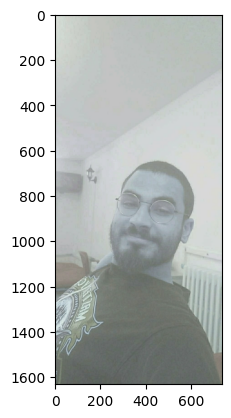

In [ ]:
#NE SURTOUT PAS EXECUTER
for image in aug_imgs:
    plt.imshow(image)

In [ ]:
# Import standard dependencies
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import uuid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import tensorflow as tf
import os
import numpy as np

In [ ]:
INPUT_PATH='/content/drive/MyDrive/Reconnaissance/Faces/input_images'
TRUE_PATH='/content/drive/MyDrive/Reconnaissance/Faces/true_images'
FALSE_PATH='/content/drive/MyDrive/Reconnaissance/Faces/false_images'

In [ ]:
input_fileset = tf.data.Dataset.list_files(INPUT_PATH+'/*.jpg').take(20)
true_fileset= tf.data.Dataset.list_files(TRUE_PATH+'/*.jpg').take(20)
false_fileset = tf.data.Dataset.list_files(FALSE_PATH+'/*.png').take(20)

In [ ]:
input_fileset = tf.data.Dataset.list_files(INPUT_PATH+'/*.jpg').take(2000)
true_fileset= tf.data.Dataset.list_files(TRUE_PATH+'/*.jpg').take(2000)
false_fileset = tf.data.Dataset.list_files(FALSE_PATH+'/*.png').take(2000)

In [ ]:
input_fileset,true_fileset,false_fileset

(<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>)

In [ ]:
dir_test = input_fileset.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'/content/drive/MyDrive/Reconnaissance/Faces/input_images/ee2b0af8-c609-11ee-9aac-0242ac1c0002.jpg'


In [ ]:
def access_imgfiles_and_preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0

    return img

In [ ]:
trueset = tf.data.Dataset.zip((input_fileset, true_fileset, tf.data.Dataset.from_tensor_slices(tf.ones(len(input_fileset)))))
falseset = tf.data.Dataset.zip((input_fileset, false_fileset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(input_fileset)))))
dataset = trueset.concatenate(falseset)

In [ ]:
def preprocess_dataset(input_file, validation_file, label):
    return(access_imgfiles_and_preprocess(input_file), access_imgfiles_and_preprocess(validation_file), label)



> Splitting the DataSet



In [ ]:
dataset = dataset.map(preprocess_dataset)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=8000)

In [ ]:
train_data = dataset.take(round(len(dataset)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
test_data = dataset.skip(round(len(dataset)*.7))
test_data = test_data.take(round(len(dataset)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
class CustomModel(Model):
    pass

In [ ]:
class CustomModel(Model):
    def train_step(self, batch):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        #x, y = data
        x = batch[:2]
        # Get label
        y = batch[2]

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}



> Embedding the Images



In [ ]:
def build_initial_model_layers():
    inp = Input(shape=(105,105,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)

    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return CustomModel(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = build_initial_model_layers()



> Making the Siamese Network to define our similarity Function so the distance would be bigger when the persons on the images are not the same



In [ ]:
class DistanceLayer(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))

    embedding = build_initial_model_layers()
    # Combine siamese distance components
    siamese_layer = DistanceLayer()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return CustomModel(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [ ]:
model = make_siamese_model()


In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (CustomModel)     (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('frmoidel.weights.best.hdf5')



> Compiling the Model and saving it



In [ ]:
model.compile(optimizer=opt, loss=binary_cross_loss)

In [ ]:
#NE PAS EXECUTER
from keras.callbacks import ModelCheckpoint

# Définir le callback pour enregistrer les points de contrôle du modèle
checkpointer = ModelCheckpoint(filepath='model_checkpoint.h5', verbose=1, save_best_only=True)

# Entraîner le modèle avec le callback
model.fit(train_data, epochs=100, callbacks=[checkpointer])
model.save('/content/drive/MyDrive/Reconnaissance/final2000siamesemodel.h5')

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[0.49906644],
       [0.49910796],
       [0.49932384],
       [0.49864733],
       [0.4997677 ],
       [0.49792585]], dtype=float32)

In [ ]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
y_pred

[0, 0, 0, 0, 0, 0]

In [ ]:
y_true

array([1., 0., 1., 1., 1., 0.], dtype=float32)

In [ ]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [ ]:
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

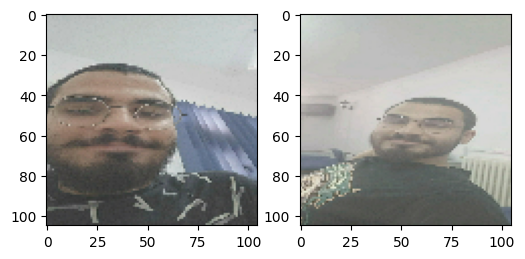

In [ ]:
# Set plot size
plt.figure(figsize=(6,6))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
ld_model = tf.keras.models.load_model('/content/drive/MyDrive/Reconnaissance/final2000siamesemodel.h5',
                                   custom_objects = {"CustomModel": CustomModel, "DistanceLayer": DistanceLayer})


In [ ]:
ld_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.9999934e-01],
       [6.7362143e-04],
       [9.9999928e-01],
       [1.0000000e+00],
       [9.9978268e-01],
       [8.1200844e-05]], dtype=float32)

In [ ]:
ld_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (CustomModel)     (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     



> Testing our model with Images not implemented before for verification



In [ ]:
def verify_image(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir('/content/drive/MyDrive/Reconnaissance/Faces/verification_images_test'):
        input_img = access_imgfiles_and_preprocess('/content/drive/MyDrive/Reconnaissance/Faces/input_image_test/4.jpg')
        validation_img = access_imgfiles_and_preprocess(os.path.join('/content/drive/MyDrive/Reconnaissance/Faces/verification_images_test', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir('/content/drive/MyDrive/Reconnaissance/Faces/verification_images_test'))
    print(verification)
    verified = verification > verification_threshold
    print(verification_threshold)
    return results, verified

In [ ]:
results, verified = verify_image(ld_model, 0.5, 0.5)
verified

1/1 [==============================] - 0s 258ms/step
0.6666666666666666
0.5


True